In [189]:
import os
from argparse import Namespace
from pathlib import Path
import librosa
from tqdm import tqdm
import noisereduce as nr
import json
import numpy as np
import pandas as pd

import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import torchaudio.functional as F
import torchaudio.transforms as T

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings(action='ignore')

n_fft = 2048
win_length = 256
hop_length = 128
n_mfcc = 64
n_mels = 128

In [190]:
# CONFIGURATIONS
IS_KAGGLE = True
if IS_KAGGLE:
    ROOT_DIR = Path('../../input/birdclef-2022')
else:
    ROOT_DIR = Path('../../datasets/birdclef-2022')
DATA_DIR = ROOT_DIR / "train_audio"

# Plot utils

In [191]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_spectrogram_from_torch(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        return Audio(waveform[0], rate=sample_rate)
    elif num_channels == 2:
        return Audio((waveform[0], waveform[1]), rate=sample_rate)
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  print(f'End_time: {end_time}')
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

In [192]:
import torch_audiomentations as audiomentations


# Initialize augmentation callable
apply_augmentation = audiomentations.Compose(
    transforms=[
        audiomentations.TimeInversion(),
        audiomentations.Shift()
    ]
)


In [193]:
from math import ceil


def crop_or_pad(y, length, sr, train=True, offset=0, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if not train:
            start = 0 + offset
        elif probs is None:
            start = np.random.randint(len(y) - length)
#             lower_2_segment = [0, length + 1]
#             upper_2_segment = [len(y) - 2 * length, len(y) - length]
#             random_value_from_lower_segment = np.random.randint(0, length + 1)
#             random_value_from_upper_segment = np.random.randint(len(y) - 2 * length, len(y) - length -1)
#             start = np.random.choice([random_value_from_lower_segment, random_value_from_upper_segment])
        else:
            start = (
                    np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start: start + length]

    return torch.from_numpy(y).float()

def compute_deltas(sg, width=9, order=1):
    def librosa_delta(data, order=1, width=9):
        return torch.from_numpy(librosa.feature.delta(data.numpy(), order=order, width=width))

    if sg.shape[1] < width:
        raise ValueError(
            f"""Delta not possible with current settings, inputs must be wider than
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width"""
        )
    new_channels = [
        torch.stack([c, librosa_delta(c, order=1), librosa_delta(c, order=2)]) for c in sg
    ]
    sg.data = torch.cat(new_channels, dim=0)
    return sg

audio2mfcc = torchaudio.transforms.MFCC(n_mfcc=n_mfcc, 
                                        melkwargs={'n_fft':n_fft, 'hop_length':hop_length, 'n_mels':n_mels})    
audio2specs = torchaudio.transforms.Spectrogram(n_fft=n_fft, 
                                        hop_length=hop_length)    

@torch.no_grad()
def create_mfcc(
        fname: str,
        reduce_noise: bool = False,
        frame_size: int = 5,
        sr: int = 16000,
        train: bool = True,
        remove_silence = False,
    ) -> list:
    waveform, sample_rate = torchaudio.load(fname)
    # print(f"Input: {waveform.size()}")

    # DownMixMono: convert to one channel. Some files have two channels
    waveform = waveform.contiguous().mean(-2).unsqueeze(-2).float()
    # print(f"DownMixMono: {waveform.size()}")

    # Convert to 16000Hz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resample(waveform)
    # print(f"Resample: {waveform.size()}")

    waveform = crop_or_pad(
        waveform.squeeze().numpy(),
        length=frame_size * sr,
        sr=sr,
        train=train
    )
    waveform = waveform.unsqueeze(0)
    # print(f"ResizeSignal: {waveform.size()}")
    if remove_silence:
        waveform = torchaudio.functional.vad(waveform, sr)
    
    if reduce_noise:
        waveform = torch.tensor(nr.reduce_noise(
            y=waveform, sr=sample_rate, win_length=256, use_tqdm=False, n_jobs=2,
        ))

    # print(f"Before mfcc: {waveform.size()}")
    spectrograms = audio2mfcc(waveform)
    # print(f"MFCC: {spectrograms.size()}")
    mfcc = compute_deltas(spectrograms)
    # print(f"Delta: {spectrograms.size()}")
#     mfcc = mfcc.float().div_(255.)
    return mfcc, waveform, sample_rate

@torch.no_grad()
def create_spectrogram(
        fname: str,
        reduce_noise: bool = False,
        frame_size: int = 5,
        sr: int = 16000,
        train: bool = True,
        remove_silence = False,
    ) -> list:
    waveform, sample_rate = torchaudio.load(fname)
    # print(f"Input: {waveform.size()}")

    # DownMixMono: convert to one channel. Some files have two channels
    waveform = waveform.contiguous().mean(-2).unsqueeze(-2).float()
    # print(f"DownMixMono: {waveform.size()}")

    # Convert to 16000Hz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resample(waveform)
    # print(f"Resample: {waveform.size()}")

    waveform = crop_or_pad(
        waveform.squeeze().numpy(),
        length=frame_size * sr,
        sr=sr,
        train=train
    )
    waveform = waveform.unsqueeze(0)
    # print(f"ResizeSignal: {waveform.size()}")
    if remove_silence:
        waveform = torchaudio.functional.vad(waveform, sr)
    
    if reduce_noise:
        waveform = torch.tensor(nr.reduce_noise(
            y=waveform, sr=sample_rate, win_length=256, use_tqdm=False, n_jobs=2,
        ))

    # print(f"Before mfcc: {waveform.size()}")
    spectrogram = audio2specs(waveform)
    # print(f"MFCC: {spectrograms.size()}")
#     mfcc = compute_deltas(spectrograms)
    # print(f"Delta: {spectrograms.size()}")
#     mfcc = mfcc.float().div_(255.)
    return spectrogram, waveform, sample_rate

@torch.no_grad()
def create_mfcc_inference(
        fname: str,
        reduce_noise: bool = False,
        frame_size: int = 5,
        sr: int = 16000
    ):
    waveform, sample_rate = torchaudio.load(fname)
    # print(f"Input: {waveform.size()}")

    # DownMixMono: convert to one channel. Some files have two channels
    waveform = waveform.contiguous().mean(-2).unsqueeze(-2).float()
    # print(f"DownMixMono: {waveform.size()}")

    # Convert to 16000Hz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resample(waveform)
    # print(f"Resample: {waveform.size()}")
    
    nb = int(frame_size * sr)
    clip_mfccs = []
    for i in range(ceil(waveform.size()[-1] / nb)):
        cropped_waveform = crop_or_pad(
            waveform.squeeze().numpy(),
            length=frame_size * sr,
            sr=sr,
            train=False,
            offset=i*sr
        )
        cropped_waveform = cropped_waveform.unsqueeze(0)
        # print(f"ResizeSignal: {cropped_waveform.size()}")
        if reduce_noise:
            cropped_waveform = torch.tensor(nr.reduce_noise(
                y=cropped_waveform, sr=sample_rate, win_length=256, use_tqdm=False, n_jobs=2,
            ))
        # print(f"Before mfcc: {cropped_waveform.size()}")
        spectrograms = audio2mfcc(cropped_waveform)
        # print(f"MFCC: {spectrograms.size()}")
        mfcc = compute_deltas(spectrograms)
        # print(f"Delta: {spectrograms.size()}")
#         mfcc = mfcc.float().div_(255.)
        clip_mfccs.append(mfcc)
    return torch.stack((clip_mfccs))

In [194]:
# Debug
from IPython.display import Audio, display
# fname = ROOT_DIR /"test_soundscapes/soundscape_453028782.ogg"
fname = ROOT_DIR / "train_audio/dunlin/XC588428.ogg"
spec = create_mfcc_inference(fname)
print(len(spec))
print(spec[0].size())

1
torch.Size([3, 64, 626])


# Augmentation

../../input/birdclef-2022/train_audio/dunlin/XC588428.ogg


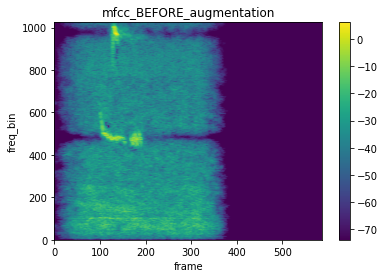

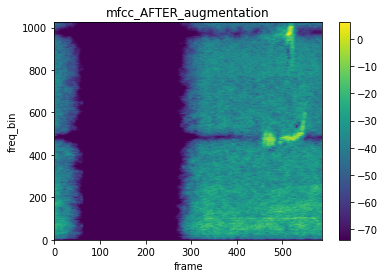

32000
torch.Size([1, 75200])


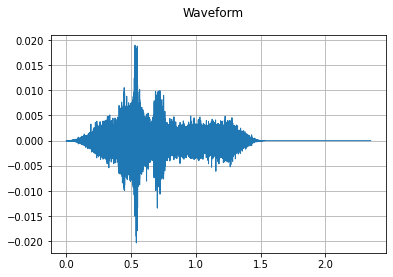

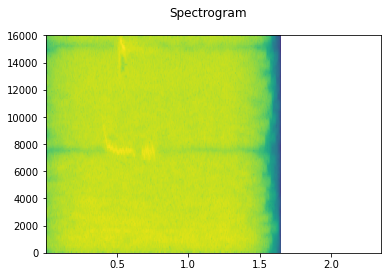

In [195]:
import glob
import random
audio_files = glob.glob(str(DATA_DIR/'**/*.ogg'), recursive=True)
# fname = random.choice(audio_files)
# fname = '../../input/birdclef-2022/train_audio/houspa/XC197826.ogg'
print(fname)

# Debug
# audio_tensor, waveform, sample_rate = create_mfcc(fname, remove_silence=True, train = True)
audio_tensor, waveform, sample_rate = create_spectrogram(fname, 
                                                         remove_silence=True, 
                                                         reduce_noise = True,
                                                         train = True)
plot_spectrogram_from_torch(audio_tensor[0], title='mfcc_BEFORE_augmentation')
# waveform, sample_rate = torchaudio.load(fname)

# Apply audiomentations
audio_tensor = apply_augmentation(audio_tensor, sample_rate=sample_rate)
plot_spectrogram_from_torch(audio_tensor[0], title='mfcc_AFTER_augmentation')
print(sample_rate)
print(waveform.shape)

plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
# pitch = F.detect_pitch_frequency(waveform, sample_rate)
# print(pitch.shape)
# plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)



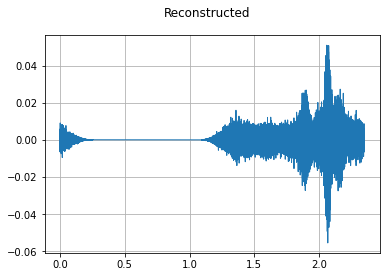

In [196]:
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform_reconstructed = griffin_lim(audio_tensor)

plot_waveform(waveform_reconstructed, sample_rate, title="Reconstructed")
play_audio(waveform_reconstructed, sample_rate)